# Exploring the Social Network Graph

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import csv

#first, read the graph using the edgelist
G = nx.read_edgelist("/content/drive/Shareddrives/cs224w/vent.edgelist")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


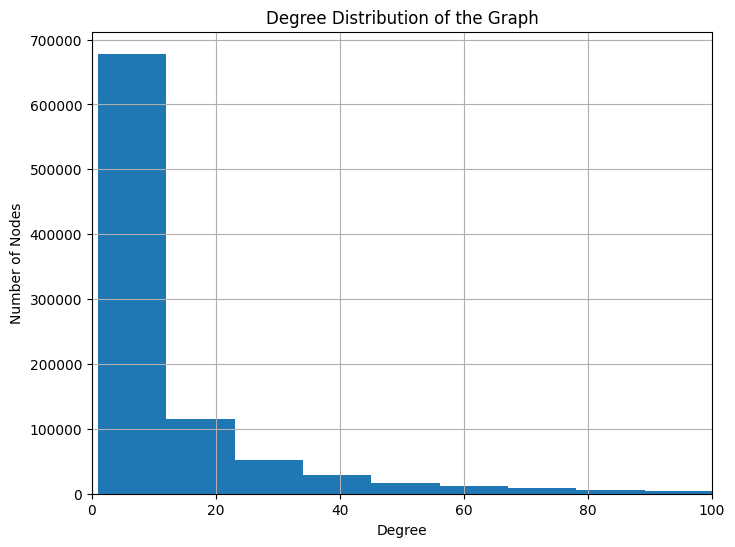

In [ ]:
# what does the degree distribution look like for this graph?

# Get the degree of each node
degree_sequence = [degree for node, degree in G.degree()]

# Plot the degree distribution - to help us determine what threshold to set when
# preprocessing
plt.figure(figsize=(8, 6))
plt.xlim(0,100)
plt.hist(degree_sequence, bins=10000)
plt.title("Degree Distribution of the Graph")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

In [ ]:
# how many nodes?
num_nodes = len(G.nodes)
print("Number of nodes:", num_nodes)

Number of nodes: 946459


In [ ]:
# no isolated nodes ...
isolated_nodes = [node for node, degree in G.degree() if degree == 0]
print(len(isolated_nodes))

In [ ]:
# if any, remove selfloops since not relevant for our applications
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
# what are the connected components of this graph?
components = nx.connected_components(G)
component_lens = [len(c) for c in sorted(components, key=len, reverse=True)]
print(component_lens)

[937796, 105, 68, 48, 47, 44, 37, 35, 31, 31, 26, 25, 24, 23, 23, 22, 22, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 19, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 15, 15, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
import networkx.algorithms.community as nx_comm

# what are the communities in this graph? we want to pick a medium size
# community to accomodate api and memory limits

communities = nx_comm.louvain_communities(G)
print(sorted([len(val) for val in communities])[:10])

In [ ]:
# we pick the graph with node size 25933 since it is a medium size

small_graph = [val for val in communities if len(val) == 25933]
G_sampled = G.subgraph(small_graph[0]).copy()

In [ ]:
import pickle

# write out all relevant information
with open("/content/drive/Shareddrives/cs224w/nodes_remaining.pkl", "wb") as f:
    pickle.dump(list(G_sampled.nodes()), f)

output_file = "/content/drive/Shareddrives/cs224w/vent_truncated_community.edgelist"
nx.write_edgelist(G_sampled, output_file, data=False)

# Examining Vent Text Data

In [ ]:
import dask.dataframe as dd
import csv
import pandas as pd

# first, load the data using pandas

# need to chunk it since it's a very large file
chunksize = 10 ** 8
tfr = pd.read_csv(
    '/content/drive/Shareddrives/cs224w/vents_original.csv',
    on_bad_lines='skip',
    low_memory="True",
    chunksize=chunksize,
    iterator=True)
df = pd.concat(tfr, ignore_index=True)

emotion_cat = pd.read_csv("/content/drive/Shareddrives/cs224w/emotion_categories.csv")
emotions = pd.read_csv("/content/drive/Shareddrives/cs224w/emotions.csv")

In [ ]:
# what does this table look like?
df.head()

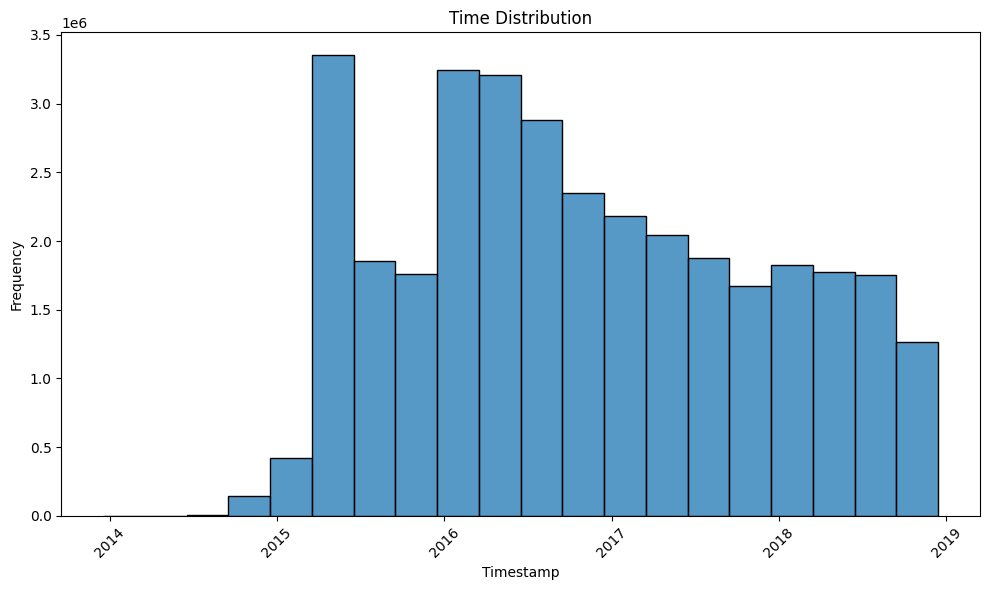

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# when were the posts made?

df['created_at'] = pd.to_datetime(df['created_at'])

# plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['created_at'], kde=False, bins=20)
plt.title('Time Distribution')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pickle

with open("/content/drive/Shareddrives/cs224w/nodes_remaining.pkl", "rb") as f:
    user_ids_to_keep = pickle.load(f)

# since we are examing a specific community, let's filter the posts to that community
df = df.loc[df.user_id.isin(user_ids_to_keep)]

In [ ]:
# how many users do we have now?
len(df.user_id.unique())

In [ ]:
import re

# preprocess the text posts
def preprocess(string):
    if not string:
        return ''

    # replace placeholders with text that is easier to encode
    replacements = {
        '_USER_REFERENCE_': 'NAME REFERENCE',
        '_URL_/': 'URL',
        '_URL_': 'URL',
    }

    for old, new in replacements.items():
        string = string.replace(old, new)

    # normalize whitespace (some posts have many new lines)
    return ' '.join(string.split())

df['text_cleaned'] = df['text'].apply(preprocess)
df.drop(["text"], axis=1, inplace=True)

# join in the emotional categories and labels from the other two data files
emotion_cat["emotion_category_id"] = emotion_cat["id"]
emotions = emotions.merge(emotion_cat, on='emotion_category_id', how='inner', suffixes=('_1', '_2'))

actual_emotions = emotions[["id_1", "name_1", "name_2"]]
actual_emotions = actual_emotions.rename(columns={"id_1" : "emotion_id", 'name_1': 'emotion', 'name_2': 'emotion_category'})

df = df.merge(actual_emotions, on='emotion_id')
df.drop(["emotion_id"], axis=1, inplace=True)

# processing function to remove emojis (harder to encode)
def remove_emojis(text):
    if text is None:
        return ''

    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emojis
        "\U0001F300-\U0001F5FF"  # symbols
        "\U0001F680-\U0001F6FF"  # maps
        "\U0001F1E0-\U0001F1FF"  # flags
        "\U00002702-\U000027B0"  # misc
        "\U000024C2-\U0001F251"  # misc cont
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# remove emojis from the text columnds
df['emotion'] = df['emotion'].apply(remove_emojis)
df['emotion_category'] = df['emotion_category'].apply(remove_emojis)
df['text_cleaned'] = df['text_cleaned'].apply(remove_emojis)

df.head()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# how many posts do users usually make?
# let's look at the distribution:

plt.figure(figsize=(10, 6))
sns.histplot(df["user_id"].value_counts(), bins=20)
plt.title('Time Distribution')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/Shareddrives/cs224w/vent_data_community.csv")

In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/Shareddrives/cs224w/vent_data_community.csv")

In [ ]:
data.head()

,user_id,created_at,reactions,text_cleaned,emotion,emotion_category
0,f281696f-5be8-4b4c-bc44-056ebd6f4157,2018-05-11 07:20:36.284,1.0,"DYING is 5th on trending, it almost has 300 ...",Good,Dog Day
1,f281696f-5be8-4b4c-bc44-056ebd6f4157,2018-04-20 20:26:44.275,999.0,DYING [ ] [ YIKES ] [ FUCK ] [ HELP ] _The ...,Melting,Earth Day '18
2,c4792251-3bc7-4885-a3d0-41dd239225ca,2017-11-29 11:51:05.374,0.0,Wheres the suicidal option on here,Sad,Sadness
3,c4792251-3bc7-4885-a3d0-41dd239225ca,2017-10-07 22:29:01.744,0.0,I got stood up today... that makes this the th...,Disappointed,Sadness
4,c4792251-3bc7-4885-a3d0-41dd239225ca,2017-10-05 23:02:48.134,2.0,I hope I dodnt lose her doing something so fuc...,Ashamed,Sadness
